# Time-Lagged Autoencoders

This homework is based and inspired by the following paper https://arxiv.org/pdf/1710.11239.pdf. Basically, we have a dataset with 4 states, which we will try to cluster using time-lagged autoencoders.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LeakyReLU, BatchNormalization
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from sklearn.cluster import MiniBatchKMeans
from scipy.cluster.vq import whiten

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

Using TensorFlow backend.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15099658939088697401
]


## Load and prepare data

In [2]:
with np.load('./data/dimredux-challenge-01-data.npz') as npz:
    data_x = npz['data_x']
    state_validation_x = npz['validation_x']
    state_validation_y = npz['validation_y']
    
data_x.shape

(100000, 3)

## Hyperparams

In [3]:
input_dim = data_x.shape[1]
input_shape = (input_dim, )
target_dim = 1
labels_count = 4

hidden_layers = [256, 128]
batch_size = 128
epochs = 150
tau = 1
opitmizer=Adam()

### Define time lagging

#### Check tau and time-lagged series first. 

As we are going to try to predict the next point in the time series from the previous one, lets check the distance between them

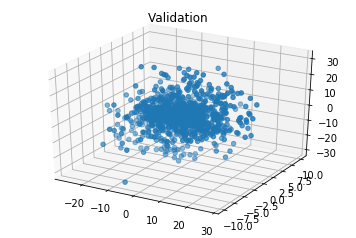

In [4]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

split_a = state_validation_x[:-tau]
split_b = state_validation_x[tau:]

data = split_a - split_b
ax.scatter(data[:, 0], data[:, 1], data[:, 2])
    
plt.title('Validation')
plt.show()

In [5]:
def time_lagg_split(x):
    return whiten(x[:-tau]), whiten(x[tau:])

train_x, train_y = time_lagg_split(data_x)
validation_x, validation_y = time_lagg_split(state_validation_x)
state_validation_x = whiten(state_validation_x)
data_x = whiten(data_x)

print(train_x.shape)
print(train_y.shape)
print(validation_x.shape)
print(validation_y.shape)

(99999, 3)
(99999, 3)
(999, 3)
(999, 3)


### Visualize data (points coloured by labels)

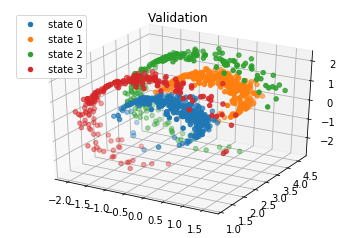

In [6]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(labels_count):
    data = state_validation_x[state_validation_y == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
plt.legend()
plt.title('Validation')
plt.show()

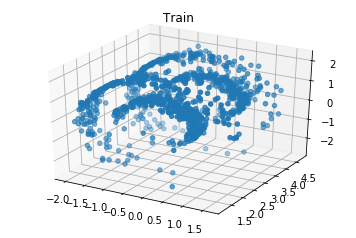

In [7]:
%matplotlib inline

fig = plt.figure()
ax = fig.gca(projection='3d')

points = data_x[::100]

ax.scatter(points[:, 0], points[:, 1], points[:, 2])
    
plt.title('Train')
plt.show()

## Define Model

### Encoder

In [8]:
encoder_input = Input(shape=input_shape, name='encoder_input')
x = encoder_input
for layer in hidden_layers:
    x = Dense(layer)(x)
    x = BatchNormalization()(x) # didn't help at all
    x = LeakyReLU(alpha=0.001)(x)
    x = Dropout(0.5)(x)
    
x = Dense(target_dim, name='encoder_output')(x)
encoder = Model(encoder_input, x, name='encoder')
encoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1024      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128)               512       
__________

### Decoder

In [9]:
decoder_input = Input(shape=(target_dim, ), name='decoder_input')
x = decoder_input
for layer in hidden_layers[::-1]:
    x = Dense(layer)(x)
    x = BatchNormalization()(x) # didn't help at all
    x = LeakyReLU(alpha=0.001)(x)
    x = Dropout(0.5)(x)
    
x = Dense(input_dim, name='decoder-output')(x)
decoder = Model(decoder_input, x, name='decoder')
decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   (None, 1)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               256       
_________________________________________________________________
batch_normalization_3 (Batch (None, 128)               512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 128)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
__________

### Autoencoder

In [10]:
auto_encoder_out = decoder(encoder(encoder_input))

auto_encoder = Model(encoder_input, auto_encoder_out, name='autoencoder')
auto_encoder.summary()
auto_encoder.compile(loss='mse', optimizer=opitmizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 3)                 0         
_________________________________________________________________
encoder (Model)              (None, 1)                 35585     
_________________________________________________________________
decoder (Model)              (None, 3)                 35587     
Total params: 71,172
Trainable params: 69,636
Non-trainable params: 1,536
_________________________________________________________________


## Fit Model

In [11]:
checkpointer = ModelCheckpoint(filepath='./model/weights.hdf5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir='./stats/dim_reduction')
stop = EarlyStopping(monitor="val_loss", min_delta=0.001, patience=5, mode="min")
history = auto_encoder.fit(train_x, train_y,
                batch_size=batch_size,
                epochs=epochs,
                verbose=1,
                validation_data=(validation_x, validation_y),
                callbacks=[checkpointer, tensorboard, stop])

Train on 99999 samples, validate on 999 samples
Epoch 1/150
99999/99999 [==============================] - 5s 51us/step - loss: 1.0200 - acc: 0.9329 - val_loss: 0.7399 - val_acc: 0.9459

Epoch 00001: val_loss improved from inf to 0.73991, saving model to ./model/weights.hdf5
Epoch 2/150
99999/99999 [==============================] - 4s 40us/step - loss: 0.7700 - acc: 0.9483 - val_loss: 0.7042 - val_acc: 0.9459

Epoch 00002: val_loss improved from 0.73991 to 0.70423, saving model to ./model/weights.hdf5
Epoch 3/150
99999/99999 [==============================] - 4s 39us/step - loss: 0.7489 - acc: 0.9483 - val_loss: 0.6778 - val_acc: 0.9459

Epoch 00003: val_loss improved from 0.70423 to 0.67783, saving model to ./model/weights.hdf5
Epoch 4/150
99999/99999 [==============================] - 4s 39us/step - loss: 0.7347 - acc: 0.9483 - val_loss: 0.6715 - val_acc: 0.9459

Epoch 00004: val_loss improved from 0.67783 to 0.67151, saving model to ./model/weights.hdf5
Epoch 5/150
99999/99999 [===

## Get best weights

In [12]:
auto_encoder.load_weights("./model/weights.hdf5")

## Define prediction, use kmeans on reduced dataset

### Prediction, kmeans

In [13]:
def predict(X):
    reduced = encoder.predict(X)
    kmeans = MiniBatchKMeans(n_clusters=labels_count)
    
    return kmeans.fit_predict(reduced), reduced

### Evaluation

In [42]:
from itertools import permutations

def evaluate(X, y):
    y_prediction, _ = predict(X)
    
    prediction_permutations = []
    best = 0
    sums = 0
    best_prediction = None
    
    labels = list(range(labels_count))
    for perm in permutations(labels):
        perm_i = np.copy(y_prediction)
        
        for i, label in enumerate(perm):
            perm_i[np.where(y_prediction == i)] = label
        prediction_permutations.append(perm_i)
                
    for prediction in prediction_permutations:
        correct = len((np.where(prediction == y))[0])
        score = (100. * correct) / (1. * len(y))
        sums += score
        
        if score > best:
            best = score
            best_prediction = prediction
    
    return best, best_prediction

In [44]:
score, best_prediction = evaluate(state_validation_x, state_validation_y)
print('Accuracy: {:.2f}%'.format(score))

# wait, 100% is weird
diff = np.where(state_validation_y != best_prediction)[0]
print('# Falsely classified: {}'.format(len(diff)))

Accuracy: 100.00%
# Falsely classified: 0


## Visualize results

### See labels in original space

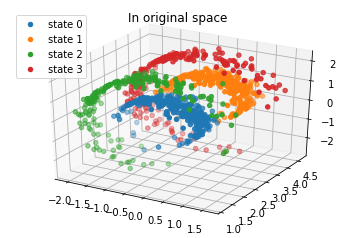

In [16]:
%matplotlib inline

def plot_clustering(dataset, plot_each=1):
    prediction, _ = predict(dataset)

    fig = plt.figure()
    ax = fig.gca(projection='3d')
    plt.title('In original space')

    for y in range(labels_count):
        data = dataset[prediction == y, :][::plot_each]
        ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state "+str(y))
    
    plt.legend()
    plt.show()
    
plot_clustering(state_validation_x)

#### Let's see how it's doing on training data

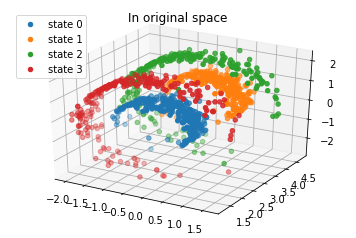

In [27]:
%matplotlib inline
plot_clustering(data_x, plot_each=100)

### See mapped space

Here we expect to see some clear space between the clusters

On the y axes we see the data, on the x-axis the labels are mapped. The second is done just to prevent overlapping so we can see better how linearly separable the data is.

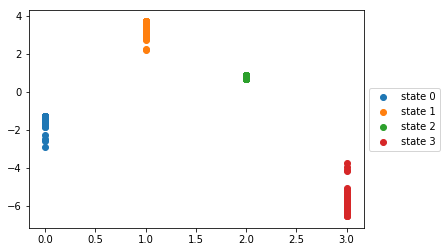

In [18]:
projection = encoder.predict(state_validation_x)

fig = plt.figure()
ax = fig.add_subplot(111)

for y in range(labels_count):
    data = projection[state_validation_y == y, :]
    ax.scatter(np.ones(len(data)) * y, data[:, 0], label="state " + str(y))
    
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#### Histograms are better

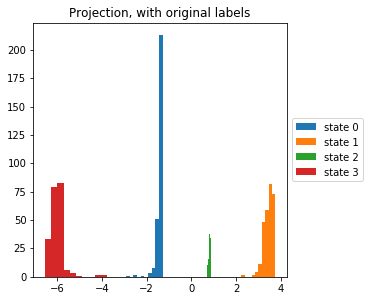

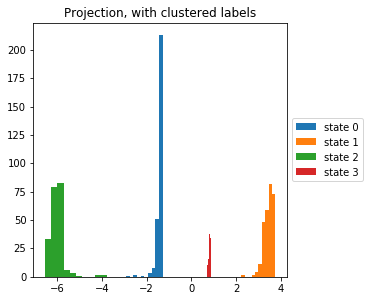

In [19]:
plt.rcParams['figure.figsize'] = 10, 10

fig = plt.figure()
ax = plt.subplot(122)

labels, projection = predict(state_validation_x)
for state in range(4):
    plt.title("Projection, with original labels")
    plt.hist(projection[state_validation_y == state], label="state "+str(state))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_aspect(1./ax.get_data_ratio())

plt.show(ax)


### And with clustered labels

fig = plt.figure()
ax = plt.subplot(122)

for state in range(4):
    plt.title("Projection, with clustered labels")
    plt.hist(projection[labels == state], label="state "+str(state))

ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_aspect(1./ax.get_data_ratio())

plt.show(ax)

### See reconstructed space

As we can see, we can kind of extract the states from 1D space, but a the information required for reconstruction is totally lost

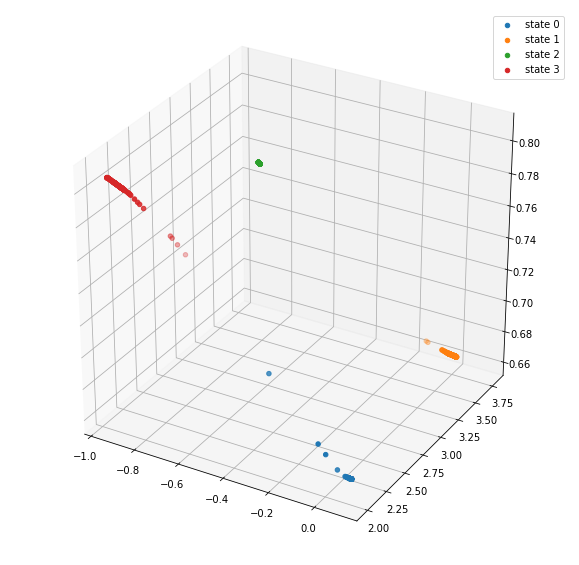

In [20]:
reconstructed = decoder.predict(projection)

fig = plt.figure()
ax = fig.gca(projection='3d')

for y in range(labels_count):
    data = reconstructed[state_validation_y == y, :]
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], label="state " + str(y))
    
plt.legend()
plt.show()

### Save predictions

In [21]:
prediction, projection = predict(data_x)
assert(prediction.shape == (100000,))
np.save('prediction.npy', prediction)